# Dragging gestures: Analysis

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os, shutil
import sympy as sp

# before attemping to import these, two, make sure you upload them to the folder
# where this ipynb is located !!!!
import display_properties
import curve_functions

# for linear regression summary
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import normal_ad

In [26]:
iodModelName = 'log(length:alpha+kappa+1)'
# iodModelName = 'kappa'
# iodModelName = 'length'
centralTendency = 'mean'
# centralTendency = 'median'

funcIoDs = {
    #'kappa*length': json.load(open('index_of_difficulty-kappa*length.json')),
    'length': json.load(open('index_of_difficulty-' + 'length' +'.json')),
    'kappa': json.load(open('index_of_difficulty-' + 'kappa' +'.json')),
    #'log(kappa+length)': json.load(open('index_of_difficulty-log(kappa+length).json')),
    'log(length:alpha+kappa+1)': json.load(open('index_of_difficulty-log(length:alpha+kappa+1).json')),
    # 'w': json.load(open('index_of_difficulty-w.json')),
}

In [8]:
# prepare folders and erase all figures
# only remove folders which are going to be changed by executing this script

figuresFoldername = 'figures'
drawingTimeHistogramsFoldername = 'drawing_time_histograms'
linearRegressionFoldername = 'linear_regressions'
takeScreenshots = True
useCroatian = True

drawingTimeHistogramsFolderPath = figuresFoldername + "/" + drawingTimeHistogramsFoldername + "/"
linearRegressionsFolderPath = figuresFoldername + "/" + linearRegressionFoldername \
    + "/" + iodModelName \
    + "/" + centralTendency + "/"
participantDataFolderPath = figuresFoldername + "/participants/"

def saveFigure(figurename):
    figurename = figurename.replace(' ', '_').replace('\n', '')
    if(takeScreenshots is True):
        plt.savefig(figurename)

def resetFigureFolder(foldername):
    if(os.path.exists(foldername)):
        shutil.rmtree(foldername)
    os.makedirs(foldername)

if(takeScreenshots is True):
    foldersToBeChanged = [
        drawingTimeHistogramsFolderPath,
        linearRegressionsFolderPath,
        participantDataFolderPath
    ]
    
    for foldername in foldersToBeChanged:
        print(foldername)
        resetFigureFolder(foldername)    

def translateWord(word):
    retval = ""
    if(word == "Cartesian"):
        retval = "Kartezijev"
    elif(word == "Polar"):
        retval = "Polarni"
    elif word == "Mouse":
        retval = "Miš"
    elif word == "Graphic tablet":
        retval = "Grafički tablet"
    elif word == "median":
        retval = "medijan"
    elif word == "mean":
        retval = "Arit.sred."
    else:
        retval = word + " - neprevedeno"
    return retval
        
def translate(words):
    if(useCroatian is False):
        return words
    
    if(type(words) is not list):
        return translateWord(words)
    
    retval = []
    for word in words:
            retval.append(translateWord(word))
    return retval

figures/drawing_time_histograms/
figures/linear_regressions/log(length:alpha+kappa+1)/mean/
figures/participants/


In [9]:
df = pd.read_csv('logs.csv')

print("Columns:", df.columns)
# indices of important columns
prAgeInd = 1
deviceInd = 2
testModeInd = 3
funcIdInd = 5
funcDiffInd = 6
funcProjInd = 7
drawTimeInd = 8

test0data = df[df['Test mode'] == 0]
test1data = df[df['Test mode'] == 1]

PROJECTIONS = ['Cartesian', 'Polar']
FUNC_IDS = [0, 1, 2, 3, 4, 5]
DEVICES = ['Mouse', 'Graphic tablet']
TEST_MODES = [0, 1]

def getIodForFunc(projection, experimentMode, funcId, iodName=iodModelName):
    test = 0
    if projection == 'Cartesian' and experimentMode == 1:
        test = 1
    elif projection == 'Polar' and experimentMode == 0:
        test = 2
    elif projection == 'Polar' and experimentMode == 1:
        test = 3
    # retval = np.log2(2 * float(funcIoDs[iodName][str(test)][str(funcId)]))
    retval = float(funcIoDs[iodName][str(test)][str(funcId)])
    return retval

def getIodsAsArray(projections, experimentModes, iodName=iodModelName):
    iodsArr = []
    for experimentMode in experimentModes:
        for projection in projections:            
            for funcId in FUNC_IDS:
                iodsArr.append(getIodForFunc(projection, experimentMode, funcId, iodName))
    return iodsArr

def getMaxIodForPlot(iodName=iodModelName):
    return round(max(getIodsAsArray(PROJECTIONS, TEST_MODES, iodName))) * 1.2

print(getIodForFunc("Polar", 1, 0))

Columns: Index(['Participant name', 'Participant age', 'Participant handedness',
       'Device', 'Test mode', 'Logging timestamp', 'Function ID',
       'Function difficulty', 'Function projection', 'Drawing time',
       'Error approx', 'Expert Mouse User', 'Expert Graphic Tablet User'],
      dtype='object')
3.988278442214543


# Drawing time distribution per function

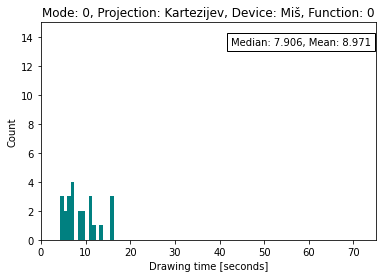

Mean:  8.9711285929375
Median:  7.90646904725


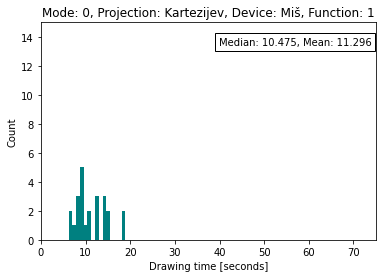

Mean:  11.295870671874999
Median:  10.47534650575


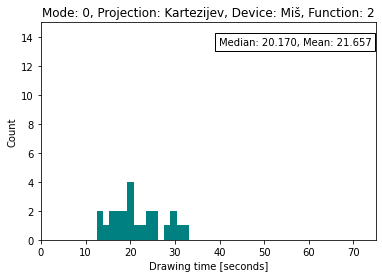

Mean:  21.656810596875
Median:  20.170229374999998


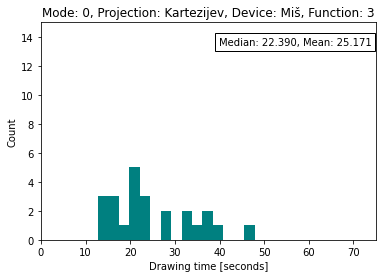

Mean:  25.171086430833338
Median:  22.390232685


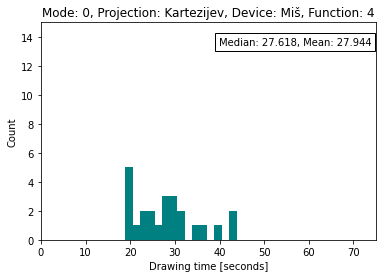

Mean:  27.944152956249997
Median:  27.617840407499997


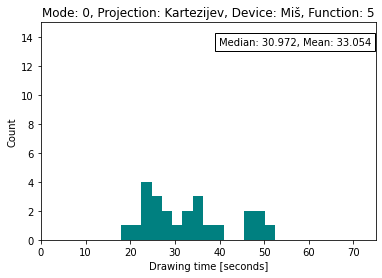

Mean:  33.05432457229167
Median:  30.9719857575


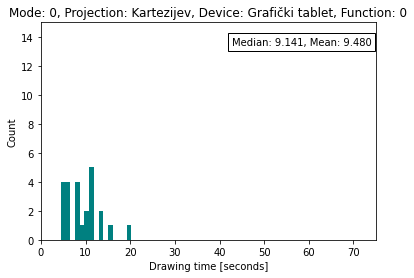

Mean:  9.480288733541666
Median:  9.141077221


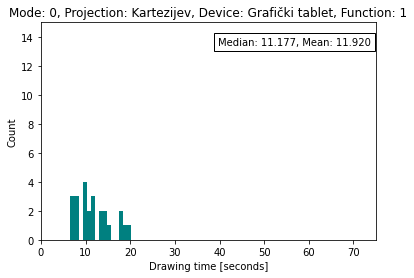

Mean:  11.920463547166667
Median:  11.17651873825


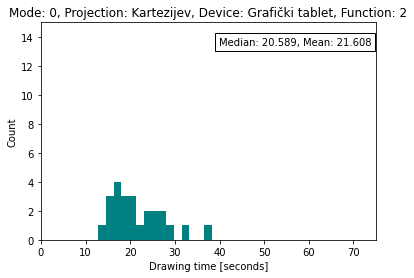

Mean:  21.607615833750003
Median:  20.589443565


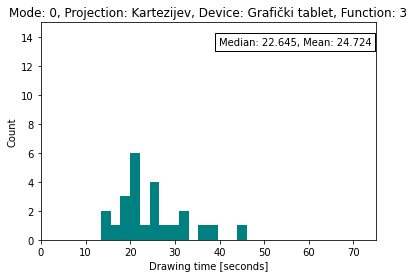

Mean:  24.724190413541667
Median:  22.644792975


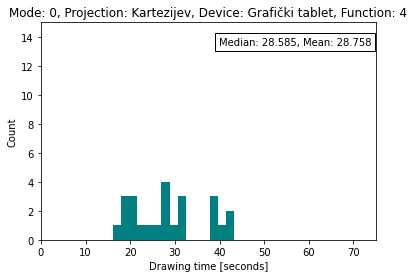

Mean:  28.757676910208335
Median:  28.5851203225


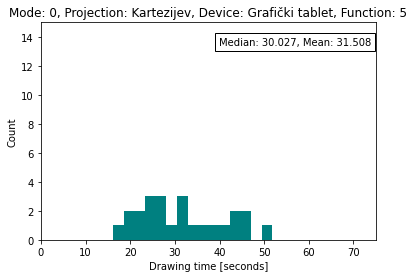

Mean:  31.508097807291666
Median:  30.026735485000003


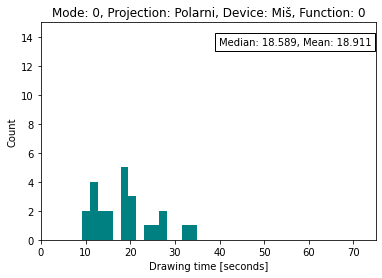

Mean:  18.910516470625
Median:  18.5890997075


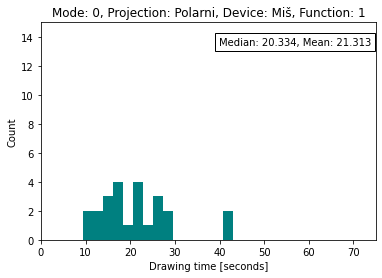

Mean:  21.313061878895837
Median:  20.33363271


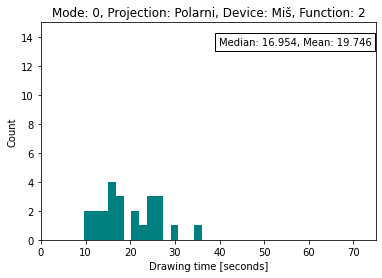

Mean:  19.74640122566667
Median:  16.953786372499998


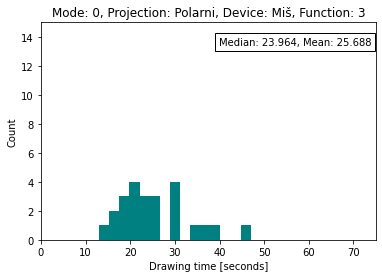

Mean:  25.687565693958334
Median:  23.9640946375


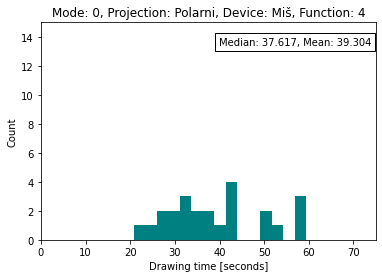

Mean:  39.30449399375
Median:  37.616853177500005


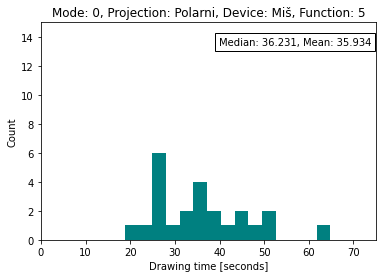

Mean:  35.93439653000001
Median:  36.2310737975


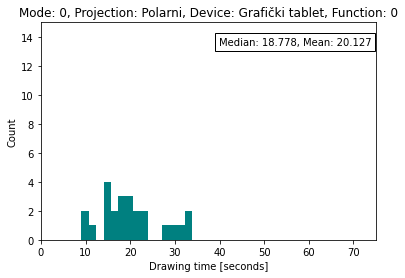

Mean:  20.1271989895625
Median:  18.778102875000002


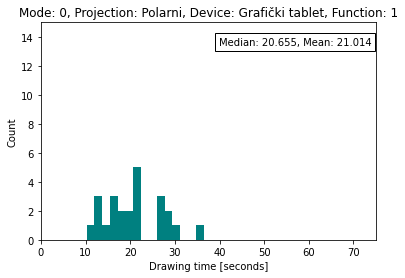

Mean:  21.0144107594375
Median:  20.6549972325


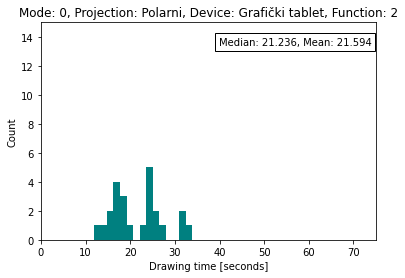

Mean:  21.594449624166668
Median:  21.2359825375


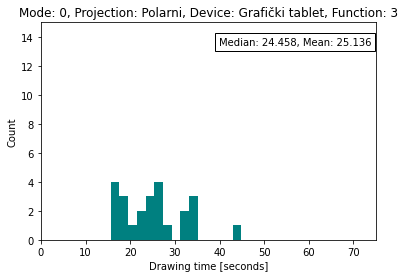

Mean:  25.135678852708335
Median:  24.45807314


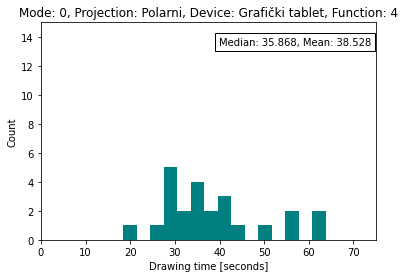

Mean:  38.52831572333333
Median:  35.867712260000005


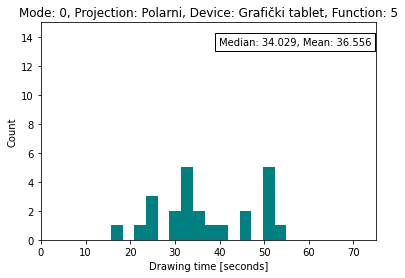

Mean:  36.556435996875
Median:  34.0293551675


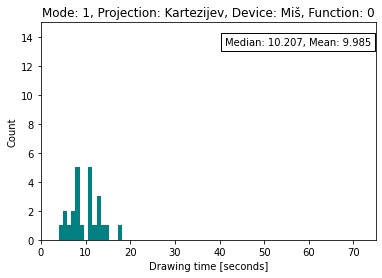

Mean:  9.985332459
Median:  10.207162738000001


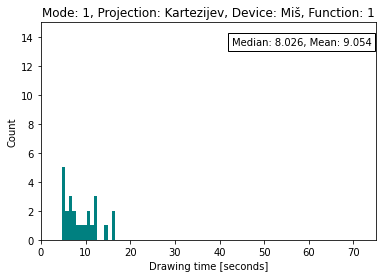

Mean:  9.053879866791666
Median:  8.0264214875


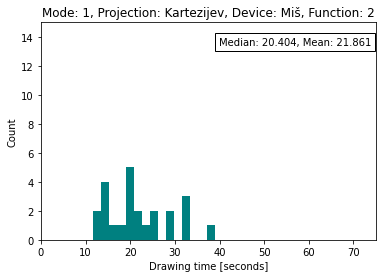

Mean:  21.860873117708334
Median:  20.404358505


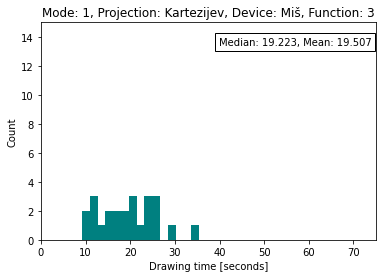

Mean:  19.506553783958335
Median:  19.2229008675


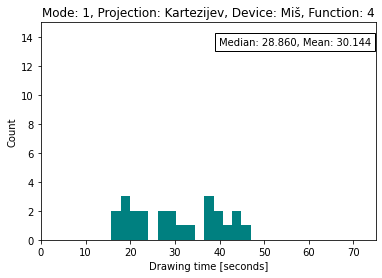

Mean:  30.1443310475
Median:  28.859760639999998


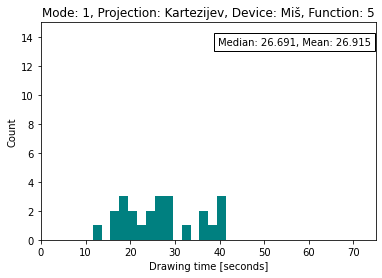

Mean:  26.915239766666662
Median:  26.6905197525


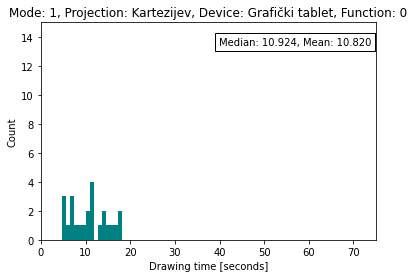

Mean:  10.819806168416667
Median:  10.924229085


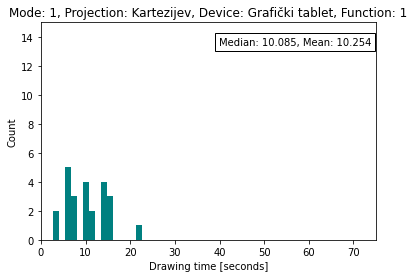

Mean:  10.254482805916668
Median:  10.08490479175


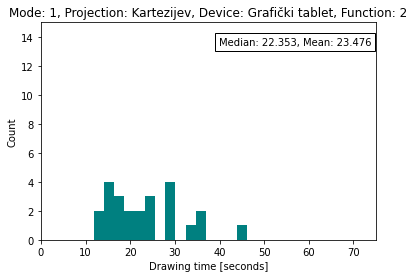

Mean:  23.475666974791665
Median:  22.3530209625


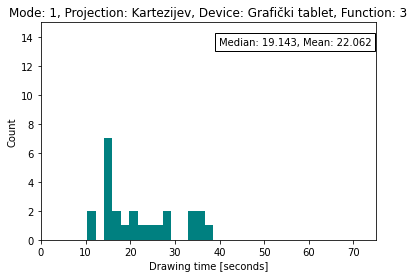

Mean:  22.062356381895835
Median:  19.142650845000002


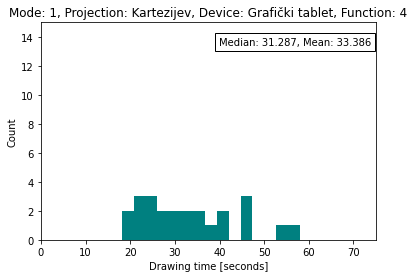

Mean:  33.386455068958334
Median:  31.287252785


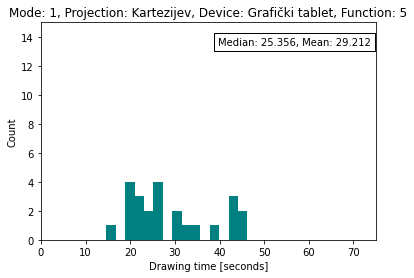

Mean:  29.211554661041664
Median:  25.356193304999998


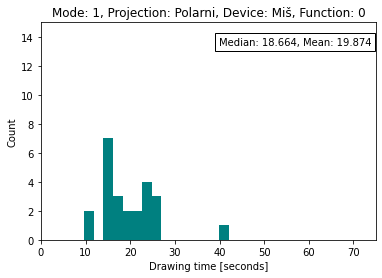

Mean:  19.873787293437502
Median:  18.664352895


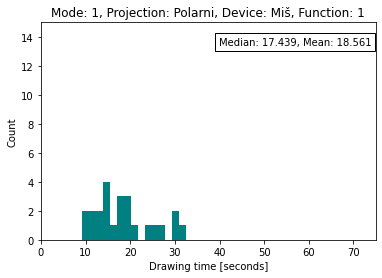

Mean:  18.561386594791667
Median:  17.43926585


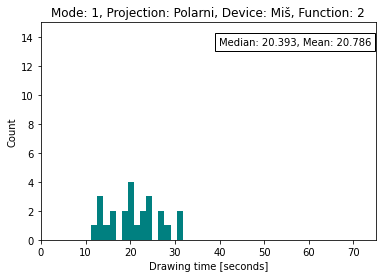

Mean:  20.785790249479167
Median:  20.39291543


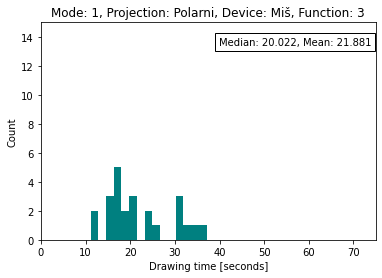

Mean:  21.88144977
Median:  20.0218842025


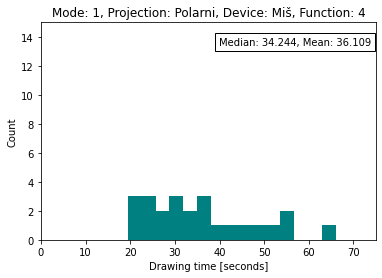

Mean:  36.10873563104167
Median:  34.2440846575


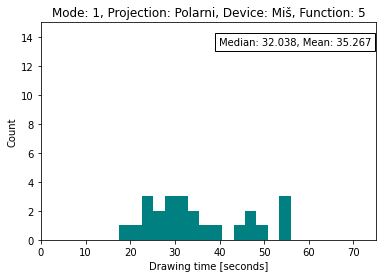

Mean:  35.26743182020834
Median:  32.0377859475


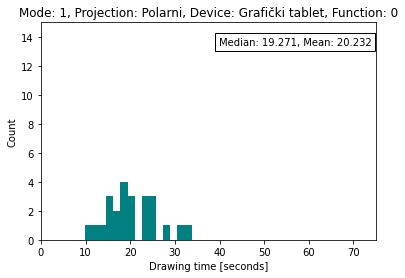

Mean:  20.231552327895834
Median:  19.270808935


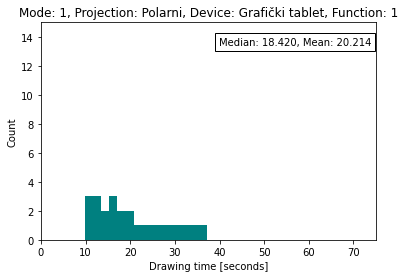

Mean:  20.213697632145834
Median:  18.41965139


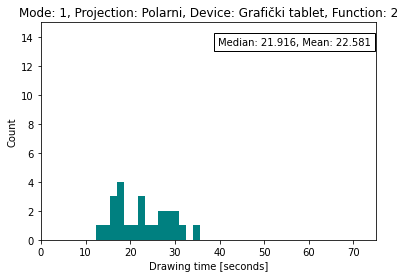

Mean:  22.580721259166666
Median:  21.9161176075


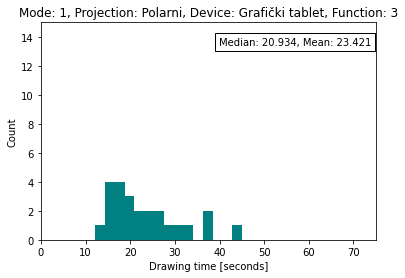

Mean:  23.420964877083332
Median:  20.93408823


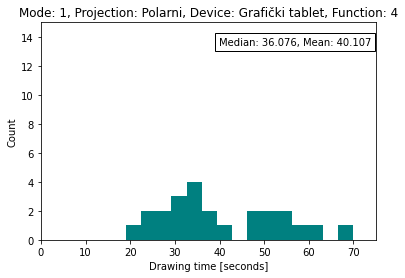

Mean:  40.107453908124995
Median:  36.075751185


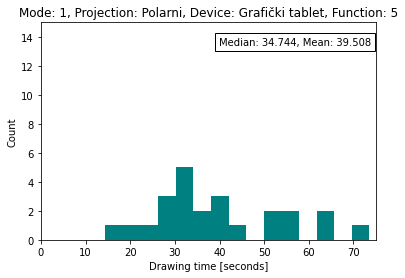

Mean:  39.50805553270833
Median:  34.7443329675


In [10]:
def getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data=df):
    # filter out by projection, Cartesian or Polar
    drawingTimes = data[data['Function projection'] == projection]
    # filter out by function ID
    drawingTimes = drawingTimes[drawingTimes['Function ID'] == funcId]
    # filter out by test (experiment mode)
    drawingTimes = drawingTimes[drawingTimes['Test mode'] == experimentMode]
    # filter out by device
    drawingTimes = drawingTimes[drawingTimes['Device'] == device]
    
    # for each user, find his/her average for this function
    participants = list(set(drawingTimes["Participant name"]))
    # find average of each participant for this function
    retval = []
    for participant in participants:
        dataForParticipant = drawingTimes[drawingTimes["Participant name"] == participant]
        avg = np.mean(dataForParticipant["Drawing time"].values)
        retval.append(avg)
    
    drawingTimes = drawingTimes['Drawing time'].values
    
    # return this to return ALL drawing times, without calculating mean for each participant
    # return drawingTimes
    return retval

projection = "Polar"
funcId = 0
device = "Mouse"
experimentMode = 0

for experimentMode in TEST_MODES:
    for projection in PROJECTIONS:
        for device in DEVICES:
            for funcId in FUNC_IDS:
                dts = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode)

                plt.figure()
                plt.hist(dts, color="teal", bins=15)
                # limits are hard-coded, if I ever have time, I will make the limits calculation smarter
                xlim = [0, 15]
                ylim = [0, 75]
                plt.ylim(xlim)
                plt.xlim(ylim)
                
                # add text with Median an Mean displayed
                text = "Median: %.3f, Mean: %.3f" % (np.median(dts), np.mean(dts))
                plt.text(ylim[1]-1, xlim[1]-1, text, ha='right', va='top', bbox=dict(facecolor='white', alpha=1))
                
                plt.title(
                    "Mode: %s, Projection: %s, Device: %s, Function: %s"
                     % (experimentMode, translate(projection), translate(device), funcId)
                )
                plt.ylabel("Count")
                plt.xlabel("Drawing time [seconds]")
                saveFigure(
                    drawingTimeHistogramsFolderPath \
                    + "mode-" + str(experimentMode) \
                    + "_device-" + device + \
                    "_function-" + str(funcId) +".png"
                )
                plt.show()
                print("Mean: ", np.mean(dts))
                print("Median: ", np.median(dts))



# Average drawing time for each curve on each input device

In [12]:
def getAvgForFunc(projection, funcId, device, experimentMode = 0, data=df):
    drawingTimes = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data)
    
    avg = np.mean(drawingTimes) if centralTendency=='mean' else np.median(drawingTimes)
    
    return avg

def getAvgsByFilter(projections, funcIds, devices, experimentModes, iodName=iodModelName, data=df):
    times = []
    iods = []
    for experimentMode in experimentModes:
        for device in devices:
            for projection in projections:
                for funcId in funcIds:
                    avg = getAvgForFunc(projection, funcId, device, experimentMode, data=data)
                    times.append(avg)
                    iods.append(getIodForFunc(projection, experimentMode, funcId, iodName))
                    # use this if you want to get ALL drawing times paired with iods
                    # avg = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data)
                    # times.extend(avg)
                    # iods.extend([getIodForFunc(projection, experimentMode, funcId)] * len(avg))
                    
    return times, iods

MAX_AVG_DRAW_TIME = round(max(getAvgsByFilter(PROJECTIONS, FUNC_IDS, DEVICES, TEST_MODES)[0]))
MAX_AVG_DRAW_TIME += 0.2 * MAX_AVG_DRAW_TIME

# for mode in TEST_MODES:
#    print("----------------- MODE:", mode)
#    for device in DEVICES:
#        print(":::", device, ":::")
#        for funcId in FUNC_IDS:
#            print("--> Function: ", funcId)
#            for projection in PROJECTIONS:
#                avg = getAvgForFunc(projection, funcId, device, mode)
#                print("\t", projection, ": ", avg)


# Test plots

In [13]:
def plotForExperiment(experimentModes, projections = PROJECTIONS):
    for experimentMode in experimentModes:
        for device in DEVICES:
            plt.figure()
            for projection in projections: 
                times = []
                for funcId in funcIds:
                    times.append(getAvgForFunc(projection, funcId, device, experimentMode))

                iods = (getIodsAsArray([projection], [experimentMode]))
                plt.scatter(iods, times, label=projection)


            plt.ylabel("Drawing time (s)")
            plt.xlabel("Index of difficulty")
            plt.ylim([0, MAX_AVG_DRAW_TIME])
            plt.xlim([0, getMaxIodForPlot()])
            plt.legend(loc='upper left')
            plt.title("Experiment %d, %s, %s" %(experimentMode, device, projections) )
            
            plt.show()

## Test plots

In [14]:
# plotForExperiment([0, 1])

# Linear regression

In [15]:
def calculateResiduals(model, x, y):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(x)
    residuals = abs(y) - abs(predictions)
    return residuals, predictions


def checkLinearAssumption(model, x, y, axes):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    residuals, predictions = calculateResiduals(model, x, y)
    
    # Plotting the actual vs predicted values
    axes.scatter(x=y, y=predictions, color="coral", edgecolors="grey")
    axes.axis("equal")
    axes.set_title("Actual vs Predicted")
    axes.set_xlabel("Actual")
    axes.set_ylabel("Predicted")
    axes.grid(True)
        
    # Plotting the diagonal line
    lineCoords = np.arange(np.min(predictions), np.max(predictions))
    axes.plot(lineCoords, lineCoords, color="black")
    return axes

def normalErrorsAssumption(model, x, y, axes, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    residuals, predictions = calculateResiduals(model, x, y)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(residuals)[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    axes.set_title('Distribution of Residuals')
    sns.histplot(residuals, ax=axes)
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

        
def multicollinearityAssumption(model, x, y, axes, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    sns.heatmap(pd.DataFrame(x, columns=feature_names).corr(), annot=True, ax=axes)
    axes.set_title('Correlation of Variables')
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(x.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

        
def autocorrelationAssumption(model, x, y):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    residuals, predictions = calculateResiduals(model, x, y)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(residuals)
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

def homoscedasticityAssumption(model, x, y, axes):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    residuals, predictions = calculateResiduals(model, x, y)

    # Plotting the residuals
    indices = np.arange(0, len(residuals))
    axes.scatter(x=indices, y=residuals, alpha=0.5)
    axes.plot(np.repeat(0, np.max(indices) + 1), color='darkorange', linestyle='--')
    axes.set_title('Residuals')

    
def testRegressionAssumptions(reg, x, y, title):
    figure, axes = plt.subplots(1, 3)
    figure.set_size_inches(15, 5)
    checkLinearAssumption(reg, x, y, axes[0])
    normalErrorsAssumption(reg, x, y, axes[1])
    # multicollinearityAssumption(reg, x, y, axes[1, 0])
    autocorrelationAssumption(reg, x, y)
    homoscedasticityAssumption(reg, x, y, axes[2])
    
    st = figure.suptitle(title)
    figure.tight_layout(pad=2)
    # shift subplots down:
    st.set_y(1)
    figure.subplots_adjust(top=0.85)
    
    saveFigure(linearRegressionsFolderPath + "_assumptions_" + title.replace(' ', '_').replace('\n', ''))
    plt.close(figure)


def getBasePlotTitle(projections, device, experimentModes):
    return "Linear regression for %s, %s, mode=%s,\nCentral Tendency=%s,Index Of Difficulty=%s" \
                   %(projections, device, experimentModes, centralTendency, iodModelName)

def getRegressionCoefficients(reg):
    x1 = 0
    x2 = 1
    y1, y2 = reg.predict(np.array([[x1], [x2]]))
    # Coefficients: y = ax + b
    b = y1
    a = (y2 - y1) / (x2 - x1)
    return a, b

# get x and y data for linear regression
def getDataForRegression(projections, experimentModes, device):
    y, iods = np.array(getAvgsByFilter(projections, FUNC_IDS, [device], experimentModes))
    x = [[iod] for iod in iods]
    return x, y

def getFormattedRegressionMetrics(reg, x, y):
    a, b = getRegressionCoefficients(reg)
    y_predicted = reg.predict(x)
    mse = metrics.mean_squared_error(y_predicted, y)
    rmspe = (np.sqrt(np.mean(np.square((y_predicted - y) / y_predicted)))) * 100
    print(rmspe)
    return 'y = %.3fx + %.3f\nR^2 = %.3f\nRMSE = %.3f\nRMSPE = %.3f%%' % (a, b, reg.score(x, y), np.sqrt(mse), rmspe)

# model metrics :: for evaulating the regression model
def printRegressionModelMetrics(reg, x, y):
    print(getFormattedRegressionMetrics(reg, x, y))

# training and retrieving the model 
def getRegressionModel(projections, experimentModes, device, axes):
    x, y = getDataForRegression(projections, experimentModes, device)
    reg = LinearRegression().fit(x, y)
    title = getBasePlotTitle(projections, device, experimentModes)
    plotDataAndReg(reg, x, y, title, axes)
    printRegressionModelMetrics(reg, x, y)
    testRegressionAssumptions(reg, x, y, title)

    return reg

def plotDataAndReg(reg, x, y, title, axes):
    axes.scatter(x, y, label="Experiment data", color="lightsteelblue", edgecolors="black")
    MAX_IOD = getMaxIodForPlot()

    predictX = np.linspace(1, MAX_IOD, 10)
    predictY = reg.predict([[x] for x in predictX])
    axes.plot(predictX, predictY, color="black", label="Linear regression")
    
    axes.set_ylabel("Drawing time (seconds)")
    axes.set_xlabel("Index of difficulty")
    axes.set_ylim([0, MAX_AVG_DRAW_TIME])
    axes.set_xlim([0, MAX_IOD])
    axes.grid(True)
    axes.legend(loc='upper left')
    axes.set_title(title)
    # axes.axis('scaled')
    
    axes.text(0, MAX_AVG_DRAW_TIME - 6,
             getFormattedRegressionMetrics(reg, x, y),
             ha='left', va='top',
             bbox=dict(facecolor='white', alpha=1)
    )
    

def validateRegressionModel(reg, projections, experimentModes, device, axes):  
    x, y = getDataForRegression(projections, experimentModes, device)
    title = getBasePlotTitle(projections, device, experimentModes) + " VALIDATED"
    
    testRegressionAssumptions(reg, x, y, title)
    plotDataAndReg(reg, x, y, title, axes)
    printRegressionModelMetrics(reg, x, y)
    
    
def trainRegressionModelThenValidate(projections, device):
    print("\n\nSKLEARN")
    MAX_IOD = getMaxIodForPlot()
    dim = max(MAX_IOD / 8, MAX_AVG_DRAW_TIME / 4)
    (width, height) = dim, dim
    figure, axes = plt.subplots(2)
    figure.set_size_inches(width, height)
    
    reg = getRegressionModel(projections, [0], device, axes[0])
    validateRegressionModel(reg, projections, [1], device, axes[1])

    figure.tight_layout(pad=3)
    title = getBasePlotTitle(projections, device, TEST_MODES) + " BOTH"
    saveFigure(linearRegressionsFolderPath + title.replace(' ', '_').replace('\n', ''))
    
    plt.show(figure)
    
    # print("\n\nSTATSMODELS")
    # x, y = getDataForRegression(projections, [0], device)
    # constx = sm.add_constant(x)
    # reg = sm.OLS(y, constx).fit()
    # print(reg.summary())
    



SKLEARN
6.80311505161046
6.80311505161046
y = 9.748x + -19.880
R^2 = 0.962
RMSE = 1.692
RMSPE = 6.803%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.30126902347138695
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.181037985413633
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Linear Relations

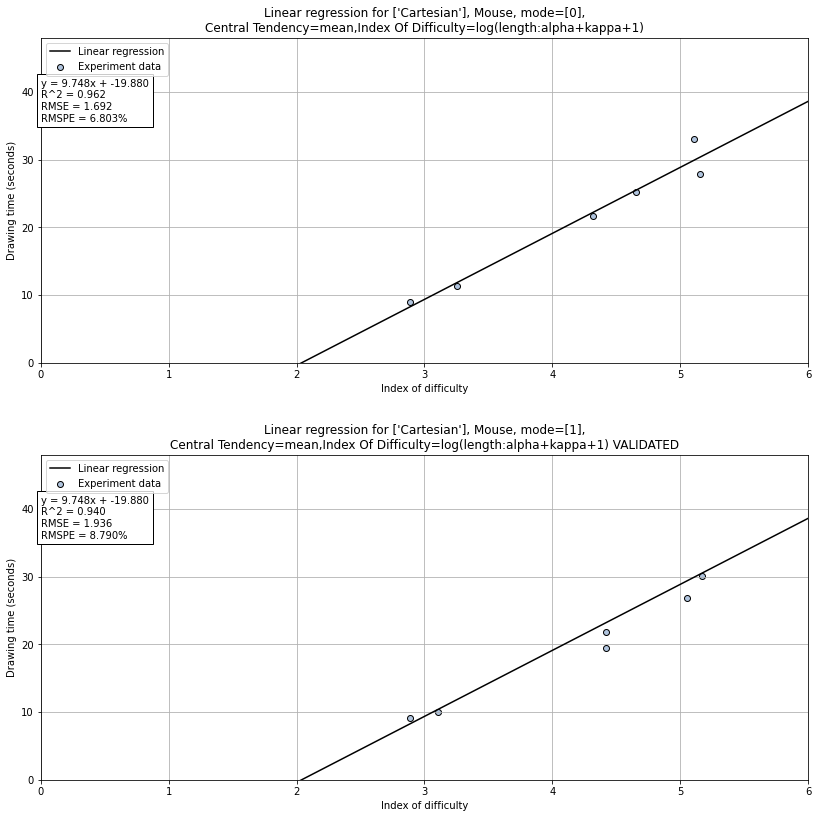



SKLEARN
4.654881402552399
4.654881402552399
y = 9.290x + -17.959
R^2 = 0.983
RMSE = 1.054
RMSPE = 4.655%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.15491501427543988
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.7566437298900222
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Linear Relati

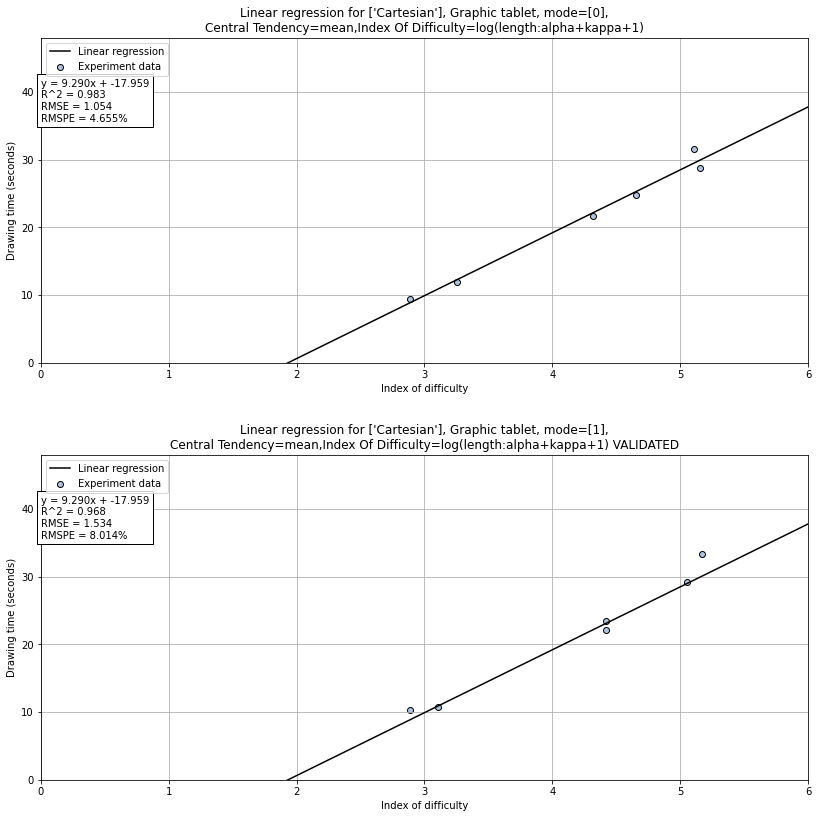



SKLEARN
9.785043484213112
9.785043484213112
y = 13.935x + -37.532
R^2 = 0.921
RMSE = 2.253
RMSPE = 9.785%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.7408377041408998
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.3891203985494407
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Linear Relati

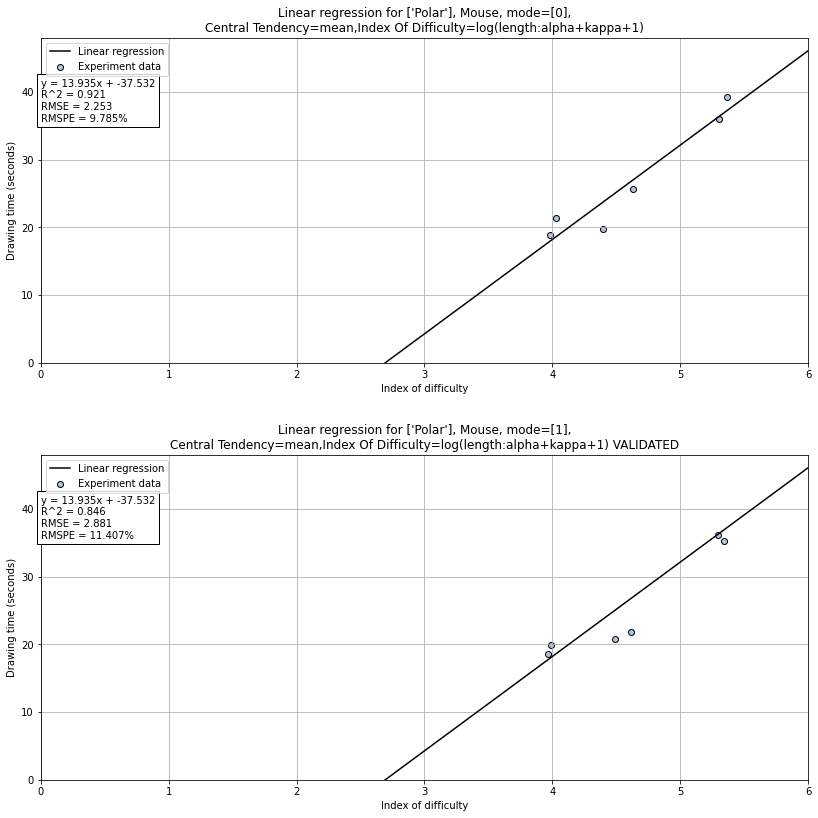



SKLEARN
7.422805110529082
7.422805110529082
y = 13.294x + -34.229
R^2 = 0.945
RMSE = 1.772
RMSPE = 7.423%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.07039046185352901
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.7730535197610615
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Linear Relat

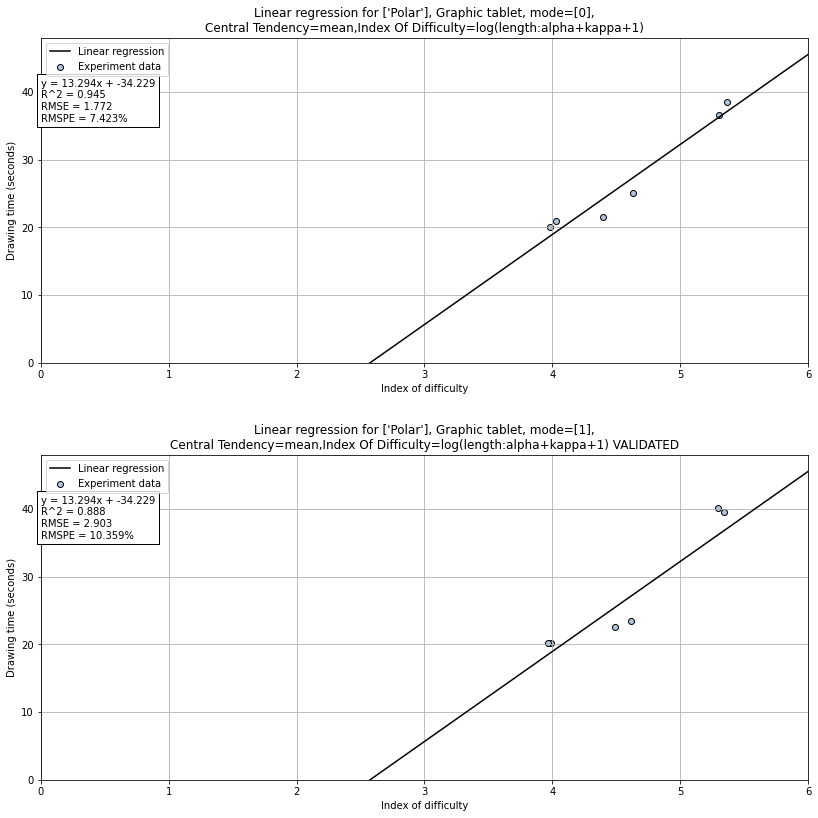



SKLEARN
11.822189521591103
11.822189521591103
y = 11.151x + -25.245
R^2 = 0.919
RMSE = 2.492
RMSPE = 11.822%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.6906957190547356
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.7657623973729193
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Linear Rel

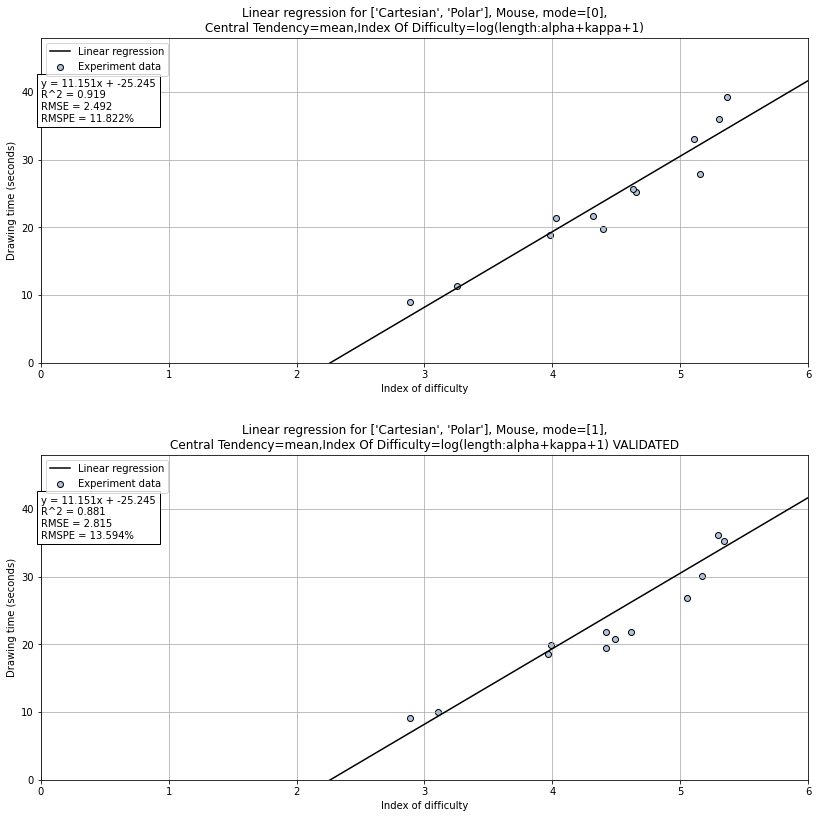



SKLEARN
9.466640496324013
9.466640496324013
y = 10.735x + -23.245
R^2 = 0.934
RMSE = 2.144
RMSPE = 9.467%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.9166750100903857
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.1476453603411438
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
Assumption 1: Line

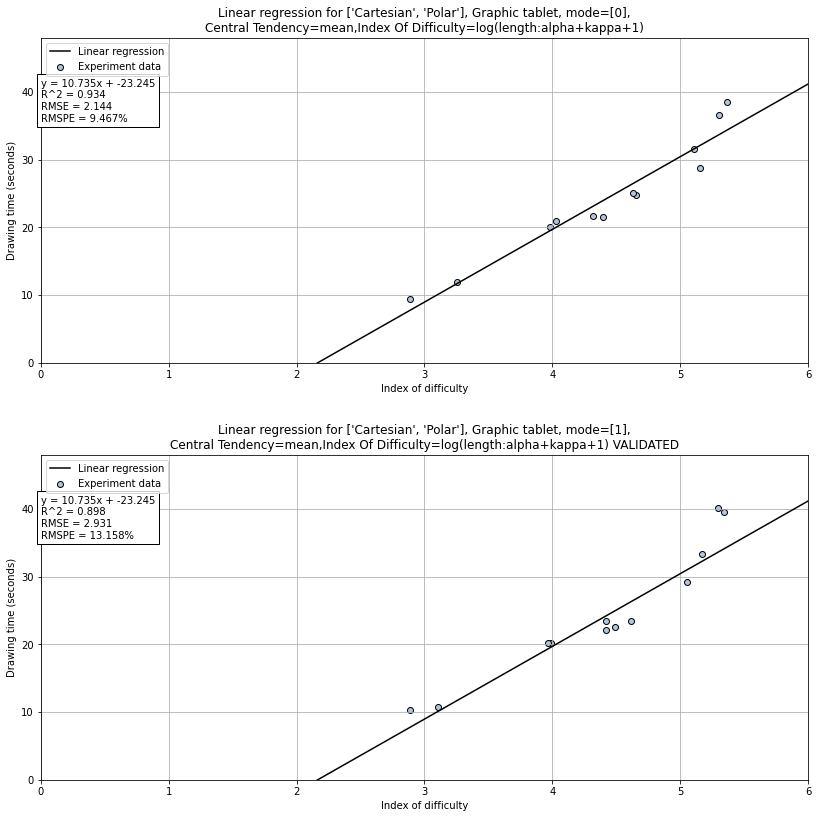

In [16]:
for projections in [["Cartesian"], ["Polar"], PROJECTIONS]:
    for device in DEVICES:
        trainRegressionModelThenValidate(projections, device)
        
        
        #reg2 = getRegressionModel(projections, [0, 1], device)
        # test the residuals as shown here: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

# Participant data

Number of participants: 24
Average participant age: 23.542
Standard deviation: 1.154

 ::::
Number of Left-handed participants: 3
Percentage of Left-handed participants 12.5 %
Number of Right-handed participants: 21
Percentage of Right-handed participants 87.5 %
Number of Ambidextrous participants: 0
Percentage of Ambidextrous participants 0.0 %

 ::::
Number of expert graphic tablet participants: 1
Percentage of expert graphic tablet participants 4.2 %
Number of expert mouse participants: 24
Percentage of expert graphic tablet participants 100.0 %

 ::::
Average drawing times
Participant;Device;Projections;Drawing Time Mean;Drawing time stdev
p-value from the test - below 0.05 generally means non-normal: 0.044465093329797
Data is not normally distributed



Participant;Device;Projections;Drawing Time Mean;Drawing time stdev
p-value from the test - below 0.05 generally means non-normal: 0.035900550648714905
Data is not normally distributed



Participant;Device;Projections;Drawing Time

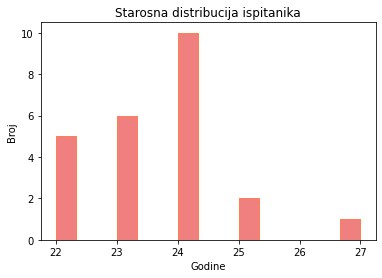

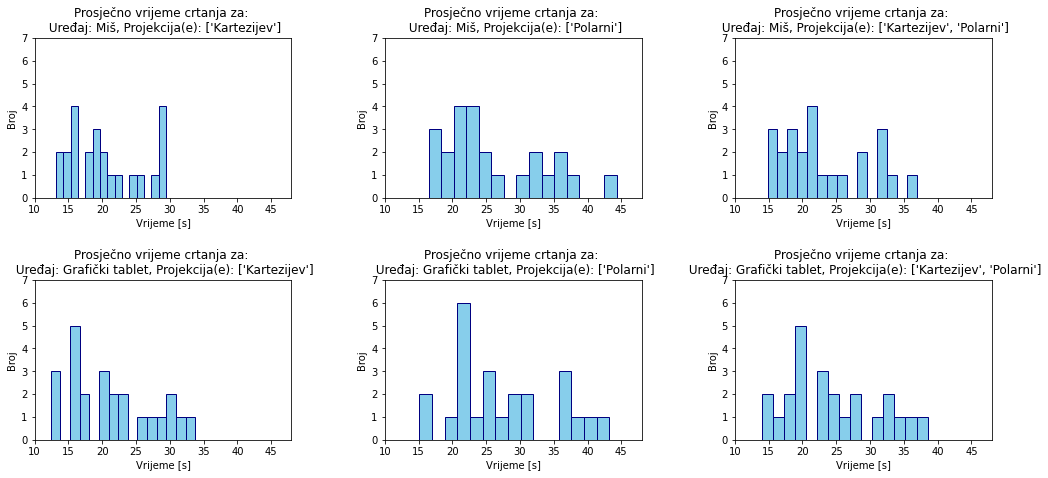

In [17]:
participants = list(set(test0data['Participant name']))

print("Number of participants:", len(participants))

ages = []
handednessFreq = {
    "Left-handed": 0,
    "Right-handed": 0,
    "Ambidextrous": 0
}
hasExpWTablet = 0
hasExpWMouse = 0
for participant in participants:
    row = df[df['Participant name'] == participant]
    age = row['Participant age'].values[0]
    handednessFreq[row['Participant handedness'].values[0]] += 1
    hasExpWTablet += row['Expert Graphic Tablet User'].values[0]
    hasExpWMouse += row['Expert Mouse User'].values[0]
    # print(participant, age)
    ages.append(age)

plt.figure()
plt.hist(ages, color="lightcoral", bins=15, edgecolor="coral")
plt.ylabel("Count")
plt.xlabel("Age")
plt.title("Participants' age")
if useCroatian is True:    
    plt.ylabel("Broj")
    plt.xlabel("Godine")
    plt.title("Starosna distribucija ispitanika")
saveFigure(participantDataFolderPath + "participant_age")
plt.plot
print("Average participant age:", round(np.mean(ages), 3))
print("Standard deviation:", round(np.std(ages), 3))

print("\n ::::")

for handedness in handednessFreq:
    freq = handednessFreq[handedness]
    print("Number of " + handedness + " participants:", freq)
    print("Percentage of " + handedness + " participants", round(freq * 1.0 / len(participants), 3)*100, '%')

print("\n ::::")
print("Number of expert graphic tablet participants:", hasExpWTablet)
print("Percentage of expert graphic tablet participants",
      round(hasExpWTablet * 1.0 / len(participants), 3)*100, '%'
)

print("Number of expert mouse participants:", hasExpWMouse)
print("Percentage of expert graphic tablet participants",
      round(hasExpWMouse * 1.0 / len(participants), 3)*100, '%'
)

print("\n ::::")
print("Average drawing times")

# Anderson-Darling test for normal distribution unknown mean and variance.
def isDataNormallyDistributed(data, p_value_thresh=0.05):
    p_value = normal_ad(data)[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Data is not normally distributed')
    else:
        print('Data is normally distributed')
    return p_value


# separator is semicolon because the 'projections' column has commas in it
separator = ';'

# Average drawing time per user
sortedParticipants = sorted(participants)
figure, axes = plt.subplots(len(DEVICES), len([["Cartesian"], ["Polar"], PROJECTIONS]))
figure.set_size_inches(15, 7)

for k, device in enumerate(DEVICES):
    for j, projections in enumerate([["Cartesian"], ["Polar"], PROJECTIONS]):
        pltData = []
        print("Participant","Device", "Projections","Drawing Time Mean", "Drawing time stdev", sep=separator)
        for i in range(len(sortedParticipants)):
            participant = sortedParticipants[i]
            dts = []
            for funcId in FUNC_IDS:
                for experimentMode in TEST_MODES:
                    drawingTimes = df[df['Participant name'] == participant]
                    drawingTimes, _ = getAvgsByFilter(projections, [funcId], [device], [experimentMode], data=drawingTimes)
                    dts.append(drawingTimes)
            # print(participant, device, projections, round(np.mean(dts), 4), round(np.std(dts), 4), sep=separator)
            pltData.append(np.mean(dts))
        # print()
        ax = axes[k][j]
        ax.hist(pltData, color='skyblue', bins=15, edgecolor="navy")

        pValueNormDist = isDataNormallyDistributed(np.array(pltData))
        
        title = "Average drawing time for \n Device %s, Projection(s) %s" %(device, projections)
        ax.set_ylabel("Count")
        ax.set_xlabel("Average drawing time [seconds]\nNorm dist p_value=%.5f" % (pValueNormDist))
        
        if useCroatian is True:
            title = "Prosječno vrijeme crtanja za: \n Uređaj: %s, Projekcija(e): %s" %(translate(device), 
                                                                                   translate(projections))
            ax.set_ylabel("Broj")
            ax.set_xlabel("Vrijeme [s]") #"\nNorm dist p_value=%.5f" % (pValueNormDist))
        ax.set_title(title)
        
        # this lim is hard-coded. if I ever have time, I should make this soft-coded :)
        ax.set_ylim([0, 7])
        ax.set_xlim([10, MAX_AVG_DRAW_TIME])
        print("\n\n")

figure.tight_layout(pad=2)
saveFigure(participantDataFolderPath + "Average_drawing_times")
plt.show()
            


## Error approximation

In [18]:
sortedParticipants = sorted(participants)

# PLEASE NOTE, this is not correct. The error rate which was calculated in the "Throughput calculation"
# part is the one that /is/ correct.

print("Participant index", "Mouse error mean", "Mouse error stdev", "Graphic tablet error mean", "Graphic tablet error stdev", sep=separator)
avgs = { "Mouse":[], "Graphic tablet":[]}
for i in range(len(sortedParticipants)):
    participant = sortedParticipants[i]
    print(participant, end='')
    for device in DEVICES:
        # epm = error per move
        epms = []
        for experimentMode in TEST_MODES:
            filename = "../Results_backup%s/%s/%s" %(experimentMode, participant, device)
            files = os.listdir(filename)
            for file in files:
                funcId = int(file[3])
                projtmp = file[10]
                projection = "Cartesian"
                if(projtmp in ["2", "3"]):
                    projection = "Polar"
                # filter out by projection, Cartesian or Polar
                errors = df[df['Function projection'] == projection]
                # filter out by function ID
                errors = errors[errors['Function ID'] == funcId]
                # filter out by test (experiment mode)
                errors = errors[errors['Test mode'] == experimentMode]
                errors = errors[errors['Participant name'] == participant]
                # filter out by device
                errors = errors[errors['Device'] == device]
                f = open(filename + "/" + file)
                                
                # NOTE: This formula is not really correct. Check "Throughput calculation" for the right one.
                errorVal = np.mean(errors["Error approx"].values) * 1.0 / len(f.readlines())
                
                epms.append(errorVal)
                f.close()
                # print(participant, projection, "(%s)" %projtmp, experimentMode, funcId, device, errorVal)
        print('', round(np.mean(epms), 6), round(np.std(epms), 6), sep=separator, end='')
        avgs[device].append(np.mean(epms))
    print()

Participant index;Mouse error mean;Mouse error stdev;Graphic tablet error mean;Graphic tablet error stdev
Marin_Vidakovic_Lipovac;0.030788;0.011263;0.030708;0.012842
Mateja Napravnik;0.02598;0.008112;0.028455;0.008879
SadilaJeMare;0.027604;0.010104;0.036846;0.014934
Shanko;0.018446;0.005908;0.018798;0.006488
Vrtni_Patuljak;0.028721;0.010888;0.028007;0.010928
Zmaj Zemun;0.022296;0.007368;0.028141;0.011593
aronta;0.025591;0.011881;0.035557;0.016128
asubasic;0.022956;0.008043;0.025117;0.009229
azahtila;0.022429;0.008087;0.024291;0.009475
bado97;0.018823;0.006911;0.023162;0.007969
dgrdinic;0.026961;0.015374;0.036031;0.017865
dmakar;0.025251;0.009425;0.034391;0.015538
kfilipcic;0.02042;0.007781;0.022104;0.009983
kknezic;0.031666;0.010652;0.033651;0.011138
kskunca;0.020906;0.007445;0.023608;0.009039
lotovic;0.02588;0.00977;0.029385;0.009761
mdudic;0.01994;0.007049;0.020253;0.006187
mduvnjak;0.019522;0.007279;0.023437;0.008675
mnjiric;0.024718;0.008685;0.028142;0.010692
mrGauss;0.015222;0.004

p-value from the test - below 0.05 generally means non-normal: 0.907888576911617
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.8390789423035425
Data is normally distributed


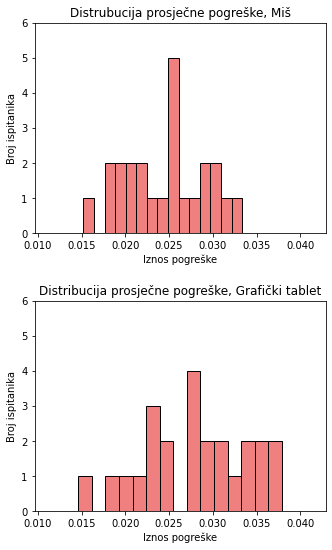

In [19]:
maxAvg = np.max([np.max(avgs["Mouse"]), np.max(avgs["Graphic tablet"])])
minAvg = np.min([np.min(avgs["Mouse"]), np.min(avgs["Graphic tablet"])])
xlim = [minAvg - 0.005, maxAvg + 0.005]
    
figure, (ax1, ax2) = plt.subplots(2)
figure.set_size_inches(5, 8)
ax1.hist(avgs["Mouse"], color="lightcoral", bins=15, edgecolor="black")

pValueNormDist = isDataNormallyDistributed(np.array(avgs["Mouse"]))

title = "Average error rate distribution, Mouse"
ax1.set_xlabel("Average error, Polar and Cartesian combined\nNorm dist p_value=%.5f" % (pValueNormDist))
ax1.set_ylabel("Participant count")

if useCroatian is True:
    title = "Distrubucija prosječne pogreške, Miš"
    ax1.set_xlabel("Iznos pogreške")
    ax1.set_ylabel("Broj ispitanika")
    
ax1.set_title(title)
ax1.set_ylim([0, 6])
ax1.set_xlim(xlim)

ax2.hist(avgs["Graphic tablet"], color="lightcoral", bins=15, edgecolor="black")

pValueNormDist = isDataNormallyDistributed(np.array(avgs["Graphic tablet"]))

title = "Average error rate distribution, Graphic tablet"

ax2.set_xlabel("Average error, Polar and Cartesian combined\nNorm dist p_value=%.5f" % (pValueNormDist))
ax2.set_ylabel("Participant count")
if useCroatian is True:
    title = "Distribucija prosječne pogreške, Grafički tablet"
    ax2.set_xlabel("Iznos pogreške")
    ax2.set_ylabel("Broj ispitanika")

ax2.set_title(title)
ax2.set_ylim([0, 6])
ax2.set_xlim(xlim)

figure.tight_layout(pad=2)
saveFigure(participantDataFolderPath + "Error_rates_dist")
plt.show()

## Throughput calculation

In [47]:
sortedParticipants = sorted(participants)

fp = curve_functions.FunctionProvider()

x = sp.Symbol("x")

# array of ALL throughputs for mouse, i.e. TPs from ALL participants
allTPsForMouse = []
allTPsForGraphicTablet = []

## NOTE::: look in calculate_integrals.y
# this throughput calculation is not exactly correct :)
for i in range(len(sortedParticipants)):
    participant = sortedParticipants[i]
    # print(participant, end='')
    # this will have two values; one for each device
    TPsForThisParticipant = {}
    
    for device in DEVICES:
        # the average throughput for this participant and this device
        # each user produces two throughputs: one for each device
        TPsForThisDevice = []
        for experimentMode in TEST_MODES:
            filename = "../Results_backup%s/%s/%s" %(experimentMode, participant, device)
            files = os.listdir(filename)
            
            # each curve was passed through twice on each device,
            # so for example, curve with ID=1 and proj=2, was passed through twice on Mouse,
            # and then twice on graphic tablet.
            # We must find the average st dev for those two passes
            
            # 4= [0,1,2,3], testmode + projection combo
            errorStDevForFunc = np.zeros((len(FUNC_IDS), 4))
            
            for file in sorted(files):

                funcId = int(file[3])
                projtmp = file[10]
                # we are searching for an entry in the logs which can tell us
                # the average MT for user
                # and the st dev of error rate for user.
                # from the stdev of error rate, we will caluclate effective width of target (W_e)
                # and from that we'll get effective index of difficulty - ID_e
                # when we divide ID_e by the MT of the user, we get the user's throughput for a single curve
                # and then we find the mean of all throughputs for this user, which we
                # then use for t-test to compare the two pointing devices
                
                f = open(filename + "/" + file)
                    
                # find the stdev of the error by dividing the sum of errors with the square root of
                # the number of points (this is the stdev formula)
                pointsDrawn = [pointDrawn.replace('\n', '') for pointDrawn in f.readlines()]
                f.close()

                test = int(projtmp)        
                difficulty = int(int(funcId) / 2)
                task = int(funcId) % 2
                real_func = fp.provide_function(difficulty, task, test)
                real_func = sp.lambdify(x, real_func)

                # ALL of the error the user had made on this specific curve
                allErrorVals = []

                for pointDrawn in pointsDrawn:
                    x_coord = float(pointDrawn.split()[0])
                    y_coord = float(pointDrawn.split()[1])
                    real_y = real_func(x_coord)

                    y_diff = abs(y_coord - real_y)

                    if(projtmp in ["2", "3"]):
                        # polar projection, erroval should be multiplied with the polar unit length
                        # so that we get effective width in inches
                        y_diff *= display_properties.POLAR_UNIT_LENGTH_IN_INCH
                    else:
                        y_diff *= display_properties.CARTESIAN_UNIT_LENGTH_IN_INCH

                    allErrorVals.append(y_diff)
                # print(np.mean(allErrorVals), np.std(allErrorVals))
                errorVal = np.std(allErrorVals)
                # print(funcId, int(projtmp))
                errorStDevForFunc[funcId][int(projtmp)] += errorVal
            # print(errorStDevForFunc)
                
            for projtmp in [0, 1, 2, 3]:
                for funcId in FUNC_IDS: 
                    
                    projection = "Cartesian"
                    if(projtmp in [2, 3]):
                        projection="Polar"
                        
                    # filter out by projection, Cartesian or Polar
                    participantMovement = df[df['Function projection'] == projection]
                    # filter out by function ID
                    participantMovement = participantMovement[participantMovement['Function ID'] == funcId]
                    # filter out by test (experiment mode)
                    participantMovement = participantMovement[participantMovement['Test mode'] == experimentMode]
                    participantMovement = participantMovement[participantMovement['Participant name'] == participant]
                    # filter out by device
                    participantMovement = participantMovement[participantMovement['Device'] == device]
                    
                    # this is from the effective target width (Fitts law), a true-tried-tested formula
                    # we have to divide it by 2 because there are two passes through this curve
                    # and we're looking for the mean of the standard deviation
                    W_e = 4.133 * errorStDevForFunc[funcId][projtmp] / 2
                    if(W_e <= 0):
                        continue

                    # calculate effective ID_e for this W_e
                    kappa = getIodForFunc(projection, experimentMode, funcId, 'kappa')

                    length = getIodForFunc(projection, experimentMode, funcId, 'length')

                    Id_e = np.log2(length / W_e + kappa + 1)

                    # movement time
                    MT = np.mean(participantMovement["Drawing time"].values)

                    # throughput for this curve and this specific user
                    TP = Id_e / MT
                    TPsForThisDevice.append(TP)
                # print(participant, projection, "(%s)" %projtmp, experimentMode, funcId, device, errorVal)
        # this is where the loop for each device ends --> we have to calculate
        # the avg throughput for this participant and this device

        TPsForThisParticipant[device] = np.mean(TPsForThisDevice)
    print(participant, TPsForThisParticipant["Mouse"], TPsForThisParticipant["Graphic tablet"], sep=separator)
    # 3/0
    allTPsForMouse.append(TPsForThisParticipant["Mouse"])
    allTPsForGraphicTablet.append(TPsForThisParticipant["Graphic tablet"])


Marin_Vidakovic_Lipovac;0.43025791104434247;0.3399318093938437
Mateja Napravnik;0.42054522870987165;0.4556440202889181
SadilaJeMare;0.42623841230117115;0.47339789147005523
Shanko;0.2661216352303222;0.24797408583375646
Vrtni_Patuljak;0.4512679746840918;0.2994263377635819
Zmaj Zemun;0.37786258919419646;0.38069439283645945
aronta;0.4823003720219239;0.414291961269352
asubasic;0.3703245121648728;0.27797232160777
azahtila;0.31427121745189884;0.33694362412103906
bado97;0.24122762612529783;0.2066039601550862
dgrdinic;0.5163084786372547;0.5452917451712115
dmakar;0.3946664583389465;0.42360413241380696
kfilipcic;0.27585373270813607;0.3080627278164566
kknezic;0.5197962867036469;0.4239366439931407
kskunca;0.27749794152886703;0.24421229768583821
lotovic;0.379184779828768;0.30472318114239266
mdudic;0.2706641721600062;0.26740402969040405
mduvnjak;0.2668457815917627;0.24214404602426584
mnjiric;0.4516894226491052;0.4337472856532623
mrGauss;0.35389781659893077;0.3052989350191953
mtvrdinic;0.4692271713826

In [ ]:
# now we should test whether the TPs are normally distributed

for i, tps in enumerate([allTPsForMouse, allTPsForGraphicTablet]):
    pValueNormDist = isDataNormallyDistributed(np.array(tps))
    device = DEVICES[i]
    
    plt.figure(figsize=(8,5))
    plt.hist(tps, color="lightgreen", edgecolor="green")
    title = "Average throughput distribution, " + device
    xlabel = "Average throughput, [bit/s]\nNorm dist p_value=%.5f" % (pValueNormDist)
    ylabel = "Participant count"

    if useCroatian is True:
        title = "Distrubucija prosječne propusnosti, " + translate(device)
        xlabel = "Propusnost [bit/s]"
        ylabel = "Broj ispitanika"

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # these limits are hard-coded, and they're here to make the histograms have the same x 
    # and y ranges on both plots
    plt.xlim([0.15, 0.65])
    plt.ylim([0, 5.5])
    
    saveFigure(participantDataFolderPath + "Throughput_dist" +  device)
    plt.show()
